In [2]:
import pandas as pd
from pathlib import Path

In [79]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.axisbelow': True})

In [4]:
from scipy.stats import spearmanr

In [5]:
data_root = Path("../data")
raw_data_root = data_root / "raw_data"

In [9]:
cleaned_arena_data_root = data_root / "intermediate" / "cleaned_arena_data"
threads_df = pd.read_parquet(cleaned_arena_data_root / "threads.parquet")
questions_df = pd.read_parquet(cleaned_arena_data_root / "questions.parquet")
responses_df = pd.read_parquet(cleaned_arena_data_root / "responses.parquet")

In [110]:
threads_df.query("thread_id == 'thread_00001100'")

,thread_id,original_row_id,timestamp,total_turns,winner,judge,primary_intent,secondary_intent,languages,client_country
1100,thread_00001100,1100,2025-03-20 05:53:19.156,1,model_b,59d27edfaa21897252bb50c9cd44fd164a3e8e27691307...,Explanation,Unassigned,[Japanese],None


In [113]:
responses_df.query("thread_id == 'thread_00003778'")

,response_id,question_id,thread_id,turn_number,model_name_llm,model_name_raw,model_side,response_text,response_role,citation_format,llm_temperature,llm_top_p,llm_max_tokens,search_context_size,user_location_country,search_engine,scrape_engine,context_manager,has_news
9948,resp_00009948,q_00004974,thread_00003778,1,gpt-4o-search-preview,gpt-4o-search-preview-high,a,The sudden drop in temperature across Pennsylv...,assistant,original,NaN,NaN,4000.0,high,None,built-in,built-in,built-in,True
9949,resp_00009949,q_00004974,thread_00003778,1,gpt-4o-search-preview,gpt-4o-search-preview-high,b,The sudden drop in temperature across Pennsylv...,assistant,arena_standard,NaN,NaN,4000.0,high,None,built-in,built-in,built-in,False


In [4]:
enriched_citations_df = pd.read_parquet(cleaned_arena_data_root / "citations_enriched.parquet")

In [29]:
len(enriched_citations_df.query("domain_classification == 'news'"))

32865

In [37]:
enriched_citations_df.query("domain_classification == 'news'")

,citation_id,response_id,citation_number,url,domain_full,domain,url_valid,citation_order,political_leaning_score,political_leaning,domain_quality_score,domain_quality,domain_classification
1,cite_00000001,resp_00000000,2,https://brainfall.com/quizzes/which-supermodel...,brainfall.com,brainfall.com,True,1,-0.057987,left_leaning,NaN,unknown,news
6,cite_00000006,resp_00000001,2,https://brainfall.com/quizzes/which-supermodel...,brainfall.com,brainfall.com,True,1,-0.057987,left_leaning,NaN,unknown,news
15,cite_00000015,resp_00000003,5,https://my.clevelandclinic.org/health/diseases...,my.clevelandclinic.org,clevelandclinic.org,True,4,-0.034916,left_leaning,0.657004,low_quality,news
16,cite_00000016,resp_00000003,6,https://kidshealth.org/en/parents/diamond-blac...,kidshealth.org,kidshealth.org,True,5,0.035248,right_leaning,0.561518,low_quality,news
33,cite_00000033,resp_00000005,6,https://www.jw.org/de/biblische-lehren/fragen/...,jw.org,jw.org,True,5,0.050423,right_leaning,0.274418,low_quality,news
...,...,...,...,...,...,...,...,...,...,...,...,...,...
365852,cite_00365852,resp_00065722,6,https://www.yahoo.com/tech/gpu-prices-2022-oct...,yahoo.com,yahoo.com,True,5,-0.072625,left_leaning,0.692128,low_quality,news
365887,cite_00365887,resp_00065728,5,https://www.pnas.org/doi/10.1073/pnas.0505414102,pnas.org,pnas.org,True,4,-0.507686,left_leaning,0.900842,high_quality,news
365909,cite_00365909,resp_00065730,5,https://www.pnas.org/doi/10.1073/pnas.0505414102,pnas.org,pnas.org,True,4,-0.507686,left_leaning,0.900842,high_quality,news
365916,cite_00365916,resp_00065730,12,https://www.hopkinsmedicine.org/health/wellnes...,hopkinsmedicine.org,hopkinsmedicine.org,True,11,-0.195278,left_leaning,0.956072,high_quality,news


In [13]:
news_citations_responses_ids = set(enriched_citations_df.query("domain_classification == 'news'").response_id)

In [15]:
len(news_citations_responses_ids)

13908

In [17]:
responses_df['has_news'] = responses_df.response_id.isin(news_citations_responses_ids)

In [20]:
thread_news_counts = responses_df.groupby("thread_id")["has_news"].agg(["sum", "count"]).reset_index()

In [21]:
thread_news_counts.columns = ["thread_id", "responses_with_news", "total_responses"]

In [30]:
thread_news_counts.query("responses_with_news > 0").sort_values(by='responses_with_news')

,thread_id,responses_with_news,total_responses
11419,thread_00011419,1,2
13273,thread_00013273,1,2
13268,thread_00013268,1,2
13266,thread_00013266,1,2
13265,thread_00013265,1,2
...,...,...,...
17797,thread_00017797,12,14
8917,thread_00008917,14,30
2568,thread_00002568,15,22
2482,thread_00002482,15,16


In [27]:
responses_df

,response_id,question_id,thread_id,turn_number,model_name_llm,model_name_raw,model_side,response_text,response_role,citation_format,llm_temperature,llm_top_p,llm_max_tokens,search_context_size,user_location_country,search_engine,scrape_engine,context_manager,has_news
0,resp_00000000,q_00000000,thread_00000000,1,sonar,sonar,a,"The term ""models"" can refer to various types o...",assistant,original,0.2,0.90,4000.0,None,None,built-in,built-in,built-in,True
1,resp_00000001,q_00000000,thread_00000000,1,sonar-reasoning,sonar-reasoning,b,## Types of Models in the Fashion Industry \n...,assistant,original,0.2,0.90,4000.0,None,None,built-in,built-in,built-in,True
2,resp_00000002,q_00000001,thread_00000001,1,gpt-4o-mini-search-preview,gpt-4o-mini-search-preview,a,مرض بلاكفان-دايموند (Diamond-Blackfan Anemia) ...,assistant,original,NaN,NaN,4000.0,medium,None,built-in,built-in,built-in,False
3,resp_00000003,q_00000001,thread_00000001,1,sonar-pro,sonar-pro,b,Diamond-Blackfan anemia (DBA) is a rare geneti...,assistant,original,0.2,0.90,4000.0,None,None,built-in,built-in,built-in,True
4,resp_00000004,q_00000002,thread_00000002,1,sonar-reasoning,sonar-reasoning,a,"Ellen White, eine bedeutende Persönlichkeit de...",assistant,original,0.2,0.90,4000.0,None,None,built-in,built-in,built-in,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65763,resp_00065763,q_00032881,thread_00024067,2,gemini-2.5-flash-preview-04-17,gemini-2.5-flash-preview-04-17-grounding,b,Начать свой бизнес на дому с минимальными затр...,assistant,arena_standard,1.0,0.95,NaN,None,None,built-in,built-in,built-in,False
65764,resp_00065764,q_00032882,thread_00024067,3,gpt-4o-search-preview,gpt-4o-search-preview,a,Анализ данных с платформы «Авито» за последние...,assistant,original,NaN,NaN,16384.0,medium,None,built-in,built-in,built-in,False
65765,resp_00065765,q_00032882,thread_00024067,3,gemini-2.5-flash-preview-04-17,gemini-2.5-flash-preview-04-17-grounding,b,Avito является одной из крупнейших онлайн-площ...,assistant,arena_standard,1.0,0.95,NaN,None,None,built-in,built-in,built-in,False
65766,resp_00065766,q_00032883,thread_00024068,1,sonar-pro,sonar-pro-high,a,2019年の上海で開催された「PPL Fighter Masters 2019」（ストリート...,assistant,arena_standard,0.2,0.90,64000.0,high,None,built-in,built-in,built-in,False


In [26]:
threads_df

,thread_id,original_row_id,timestamp,total_turns,winner,judge,primary_intent,secondary_intent,languages,client_country
0,thread_00000000,0,2025-03-18 16:39:00.550,1,tie,78996144fc08f820066fdaa66f170da6e158c24ad70c4e...,Other,Unassigned,[English],None
1,thread_00000001,1,2025-03-18 16:39:35.849,1,model_a,023f8e28f2b51ef62a7adb0fdf06709b8004773b41ca38...,Explanation,Unassigned,[Arabic],None
2,thread_00000002,2,2025-03-18 16:43:18.951,1,model_b,febd105f4f29cf47f72d9b5bf825bdb848fb009b7b0cd6...,Info Synthesis,Factual Lookup,[German],None
3,thread_00000003,3,2025-03-18 16:43:47.861,1,tie,d3560a0fe5416204140c8b1269b3ff10108c36fe59d355...,Other,Unassigned,[English],None
4,thread_00000004,4,2025-03-18 16:47:47.787,1,model_b,febd105f4f29cf47f72d9b5bf825bdb848fb009b7b0cd6...,Info Synthesis,Unassigned,"[German, English]",None
...,...,...,...,...,...,...,...,...,...,...
24064,thread_00024064,24064,2025-05-09 05:10:41.078,3,model_b,43956094e8aa8b172f5d869d2b155e6dd7a86065fd9e1f...,Guidance,Unassigned,[English],TR
24065,thread_00024065,24065,2025-05-09 05:16:52.273,1,model_b,1eda0ecd002074b1624f41b7bea304ad5f8166575705e4...,Factual Lookup,Unassigned,[Japanese],JP
24066,thread_00024066,24066,2025-05-09 05:16:59.602,6,None,eb8e298d3bf023a06c2bc40fbf35b54304d45eac20bfe9...,Explanation,Unassigned,[Korean],KR
24067,thread_00024067,24067,2025-05-09 05:17:15.568,3,None,1a1ce960efb853bcf8a7a712d0b4777460b9fcd53a1ada...,Recommendation,Unassigned,[Russian],RU


In [7]:
preference_analysis_data_root = data_root / "intermediate" / "preference_analysis"

In [86]:
news_responses_df = pd.read_parquet(preference_analysis_data_root / "news_competitions_responses.parquet")
news_citations_df = pd.read_parquet(preference_analysis_data_root / "news_competitions_citations.parquet")
news_competitions_df = pd.read_parquet(preference_analysis_data_root / "news_competitions.parquet")

news_competitions_response_signals_df = pd.read_parquet(preference_analysis_data_root / "news_competitions_response_signals.parquet")

In [95]:
news_responses_df.thread_id

,response_id,question_id,thread_id,turn_number,model_name_llm,model_name_raw,model_side,response_text,response_role,citation_format,llm_temperature,llm_top_p,llm_max_tokens,search_context_size,user_location_country,search_engine,scrape_engine,context_manager,has_news
0,resp_00000002,q_00000001,thread_00000001,1,gpt-4o-mini-search-preview,gpt-4o-mini-search-preview,a,مرض بلاكفان-دايموند (Diamond-Blackfan Anemia) ...,assistant,original,NaN,NaN,4000.0,medium,None,built-in,built-in,built-in,False
1,resp_00000003,q_00000001,thread_00000001,1,sonar-pro,sonar-pro,b,Diamond-Blackfan anemia (DBA) is a rare geneti...,assistant,original,0.2,0.90,4000.0,None,None,built-in,built-in,built-in,True
2,resp_00000004,q_00000002,thread_00000002,1,sonar-reasoning,sonar-reasoning,a,"Ellen White, eine bedeutende Persönlichkeit de...",assistant,original,0.2,0.90,4000.0,None,None,built-in,built-in,built-in,False
3,resp_00000005,q_00000002,thread_00000002,1,sonar-pro,sonar-pro,b,Basierend auf den Suchergebnissen gibt es kein...,assistant,original,0.2,0.90,4000.0,None,None,built-in,built-in,built-in,True
4,resp_00000010,q_00000005,thread_00000005,1,gpt-4o-mini-search-preview,gpt-4o-mini-search-preview,a,Kyawthuite is considered the rarest mineral on...,assistant,original,NaN,NaN,4000.0,medium,None,built-in,built-in,built-in,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8975,resp_00065703,q_00032851,thread_00024050,1,sonar-pro,sonar-pro-high,b,## Weyerhaeuser’s Use or Purchase of Vermiculi...,assistant,original,0.2,0.90,64000.0,high,None,built-in,built-in,built-in,True
8976,resp_00065714,q_00032857,thread_00024054,1,sonar-reasoning-pro,sonar-reasoning-pro-high,a,Based on the available information as of May 9...,assistant,arena_standard,0.2,0.90,64000.0,high,None,built-in,built-in,built-in,True
8977,resp_00065715,q_00032857,thread_00024054,1,gpt-4o-search-preview,gpt-4o-search-preview,b,"As of May 9, 2025, several AI ""Deep Research"" ...",assistant,arena_standard,NaN,NaN,16384.0,medium,None,built-in,built-in,built-in,True
8978,resp_00065718,q_00032859,thread_00024056,1,gpt-4o-search-preview,gpt-4o-search-preview-high-loc,a,"As of May 9, 2025, the first-quarter earnings ...",assistant,arena_standard,NaN,NaN,16384.0,high,"{'approximate': {'country': 'US'}, 'type': 'ap...",built-in,built-in,built-in,True


In [87]:
len(news_responses_df)

8980

In [88]:
len(news_competitions_response_signals_df)

8980

In [89]:
news_competitions_response_signals_df.columns

Index(['response_id', 'question_id', 'thread_id', 'turn_number',
       'model_name_llm', 'model_name_raw', 'model_side', 'response_text',
       'response_role', 'citation_format', 'llm_temperature', 'llm_top_p',
       'llm_max_tokens', 'search_context_size', 'user_location_country',
       'search_engine', 'scrape_engine', 'context_manager', 'has_news',
       'response_length', 'response_word_count', 'num_citations',
       'proportion_high_quality', 'proportion_low_quality',
       'proportion_unknown_quality', 'avg_quality_score', 'min_quality_score',
       'max_quality_score', 'proportion_left_leaning',
       'proportion_right_leaning', 'proportion_unknown_leaning',
       'avg_bias_score', 'min_bias_score', 'max_bias_score', 'bias_score_std',
       'proportion_news', 'proportion_academic', 'proportion_government',
       'proportion_social_media', 'proportion_unclassified', 'proportion_wiki',
       'proportion_gov_edu', 'proportion_tech', 'proportion_search_engine',
       

In [77]:
news_competitions_response_signals_df.query('thread_id == "thread_00018046"')

,response_id,question_id,thread_id,turn_number,model_name_llm,model_name_raw,model_side,response_text,response_role,citation_format,...,proportion_social_media,proportion_unclassified,news_domain_diversity,news_domain_diversity_ratio,winner,primary_intent,secondary_intent,total_turns,model_won,model_lost
7190,resp_00048962,q_00024481,thread_00018046,1,sonar-reasoning-pro,sonar-reasoning-pro-high,a,The question of whether artificial intelligenc...,assistant,original,...,0.111111,0.222222,3.0,1.0,model_a,Analysis,Explanation,1,True,False
7191,resp_00048963,q_00024481,thread_00018046,1,gemini-2.5-pro-exp-03-25,gemini-2.5-pro-exp-03-25-wo-search,b,That's one of the most debated and significant...,assistant,none,...,0.000000,0.000000,NaN,NaN,model_a,Analysis,Explanation,1,False,True


In [90]:
news_competitions_response_signals_df

,response_id,question_id,thread_id,turn_number,model_name_llm,model_name_raw,model_side,response_text,response_role,citation_format,...,proportion_community_blog,proportion_other,news_domain_diversity,news_domain_diversity_ratio,winner,primary_intent,secondary_intent,total_turns,model_won,model_lost
0,resp_00000002,q_00000001,thread_00000001,1,gpt-4o-mini-search-preview,gpt-4o-mini-search-preview,a,مرض بلاكفان-دايموند (Diamond-Blackfan Anemia) ...,assistant,original,...,0.0,0.000000,0.0,0.0,model_a,Explanation,Unassigned,1,True,False
1,resp_00000003,q_00000001,thread_00000001,1,sonar-pro,sonar-pro,b,Diamond-Blackfan anemia (DBA) is a rare geneti...,assistant,original,...,0.0,0.000000,2.0,1.0,model_a,Explanation,Unassigned,1,False,True
2,resp_00000004,q_00000002,thread_00000002,1,sonar-reasoning,sonar-reasoning,a,"Ellen White, eine bedeutende Persönlichkeit de...",assistant,original,...,0.0,0.000000,0.0,0.0,model_b,Info Synthesis,Factual Lookup,1,False,True
3,resp_00000005,q_00000002,thread_00000002,1,sonar-pro,sonar-pro,b,Basierend auf den Suchergebnissen gibt es kein...,assistant,original,...,0.0,0.000000,1.0,1.0,model_b,Info Synthesis,Factual Lookup,1,True,False
4,resp_00000010,q_00000005,thread_00000005,1,gpt-4o-mini-search-preview,gpt-4o-mini-search-preview,a,Kyawthuite is considered the rarest mineral on...,assistant,original,...,0.0,0.000000,3.0,1.0,model_b,Factual Lookup,Unassigned,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8975,resp_00065703,q_00032851,thread_00024050,1,sonar-pro,sonar-pro-high,b,## Weyerhaeuser’s Use or Purchase of Vermiculi...,assistant,original,...,0.0,0.000000,1.0,1.0,model_b,Info Synthesis,Analysis,1,True,False
8976,resp_00065714,q_00032857,thread_00024054,1,sonar-reasoning-pro,sonar-reasoning-pro-high,a,Based on the available information as of May 9...,assistant,arena_standard,...,0.1,0.100000,1.0,1.0,model_a,Info Synthesis,Unassigned,1,True,False
8977,resp_00065715,q_00032857,thread_00024054,1,gpt-4o-search-preview,gpt-4o-search-preview,b,"As of May 9, 2025, several AI ""Deep Research"" ...",assistant,arena_standard,...,0.0,0.000000,2.0,1.0,model_a,Info Synthesis,Unassigned,1,False,True
8978,resp_00065718,q_00032859,thread_00024056,1,gpt-4o-search-preview,gpt-4o-search-preview-high-loc,a,"As of May 9, 2025, the first-quarter earnings ...",assistant,arena_standard,...,0.0,0.000000,2.0,1.0,model_b,Analysis,Factual Lookup,1,False,True


In [85]:
news_competitions_response_signals_df[['proportion_left_leaning', 'proportion_right_leaning', 'avg_bias_score']]

,proportion_left_leaning,proportion_right_leaning,avg_bias_score
0,0.000000,0.000000,0.000000
1,0.833333,0.166667,-0.136531
2,0.200000,0.200000,-0.103811
3,0.300000,0.200000,-0.071014
4,1.000000,0.000000,-0.353437
...,...,...,...
8975,0.500000,0.100000,-0.226404
8976,0.600000,0.000000,-0.222733
8977,1.000000,0.000000,-0.251419
8978,1.000000,0.000000,-0.120106


In [82]:
news_competitions_response_signals_df[news_competitions_response_signals_df.avg_quality_score.isna()]

,response_id,question_id,thread_id,turn_number,model_name_llm,model_name_raw,model_side,response_text,response_role,citation_format,...,proportion_social_media,proportion_unclassified,news_domain_diversity,news_domain_diversity_ratio,winner,primary_intent,secondary_intent,total_turns,model_won,model_lost


In [58]:
len(news_citations_df)

60357

In [61]:
len(news_competitions_df)

3543

In [62]:
news_competitions_with_signals_df.columns

Index(['response_id', 'question_id', 'thread_id', 'turn_number',
       'model_name_llm', 'model_name_raw', 'model_side', 'response_text',
       'response_role', 'citation_format', 'llm_temperature', 'llm_top_p',
       'llm_max_tokens', 'search_context_size', 'user_location_country',
       'search_engine', 'scrape_engine', 'context_manager', 'has_news',
       'response_length', 'response_word_count', 'num_citations',
       'proportion_high_quality', 'proportion_low_quality',
       'proportion_unknown_quality', 'avg_quality_score', 'min_quality_score',
       'max_quality_score', 'proportion_left_leaning',
       'proportion_right_leaning', 'proportion_unknown_leaning',
       'avg_bias_score', 'min_bias_score', 'max_bias_score', 'bias_score_std',
       'proportion_news', 'proportion_academic', 'proportion_government',
       'proportion_social_media', 'proportion_unclassified',
       'news_domain_diversity', 'news_domain_diversity_ratio', 'winner',
       'primary_intent', 'sec

In [104]:
news_competitions_response_signals_df

,response_id,question_id,thread_id,turn_number,model_name_llm,model_name_raw,model_side,response_text,response_role,citation_format,...,proportion_community_blog,proportion_other,news_domain_diversity,news_domain_diversity_ratio,winner,primary_intent,secondary_intent,total_turns,model_won,model_lost
0,resp_00000002,q_00000001,thread_00000001,1,gpt-4o-mini-search-preview,gpt-4o-mini-search-preview,a,مرض بلاكفان-دايموند (Diamond-Blackfan Anemia) ...,assistant,original,...,0.0,0.000000,0.0,0.0,model_a,Explanation,Unassigned,1,True,False
1,resp_00000003,q_00000001,thread_00000001,1,sonar-pro,sonar-pro,b,Diamond-Blackfan anemia (DBA) is a rare geneti...,assistant,original,...,0.0,0.000000,2.0,1.0,model_a,Explanation,Unassigned,1,False,True
2,resp_00000004,q_00000002,thread_00000002,1,sonar-reasoning,sonar-reasoning,a,"Ellen White, eine bedeutende Persönlichkeit de...",assistant,original,...,0.0,0.000000,0.0,0.0,model_b,Info Synthesis,Factual Lookup,1,False,True
3,resp_00000005,q_00000002,thread_00000002,1,sonar-pro,sonar-pro,b,Basierend auf den Suchergebnissen gibt es kein...,assistant,original,...,0.0,0.000000,1.0,1.0,model_b,Info Synthesis,Factual Lookup,1,True,False
4,resp_00000010,q_00000005,thread_00000005,1,gpt-4o-mini-search-preview,gpt-4o-mini-search-preview,a,Kyawthuite is considered the rarest mineral on...,assistant,original,...,0.0,0.000000,3.0,1.0,model_b,Factual Lookup,Unassigned,1,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8975,resp_00065703,q_00032851,thread_00024050,1,sonar-pro,sonar-pro-high,b,## Weyerhaeuser’s Use or Purchase of Vermiculi...,assistant,original,...,0.0,0.000000,1.0,1.0,model_b,Info Synthesis,Analysis,1,True,False
8976,resp_00065714,q_00032857,thread_00024054,1,sonar-reasoning-pro,sonar-reasoning-pro-high,a,Based on the available information as of May 9...,assistant,arena_standard,...,0.1,0.100000,1.0,1.0,model_a,Info Synthesis,Unassigned,1,True,False
8977,resp_00065715,q_00032857,thread_00024054,1,gpt-4o-search-preview,gpt-4o-search-preview,b,"As of May 9, 2025, several AI ""Deep Research"" ...",assistant,arena_standard,...,0.0,0.000000,2.0,1.0,model_a,Info Synthesis,Unassigned,1,False,True
8978,resp_00065718,q_00032859,thread_00024056,1,gpt-4o-search-preview,gpt-4o-search-preview-high-loc,a,"As of May 9, 2025, the first-quarter earnings ...",assistant,arena_standard,...,0.0,0.000000,2.0,1.0,model_b,Analysis,Factual Lookup,1,False,True


In [8]:
battle_data_df = pd.read_parquet(preference_analysis_data_root / "battle_data.parquet")

In [10]:
len(battle_data_df)

3543

In [11]:
battle_data_df.columns

Index(['thread_id', 'model_a', 'model_b', 'winner', 'num_responses_a',
       'num_responses_b', 'primary_intent', 'secondary_intent', 'total_turns',
       'response_length_a', 'response_length_b', 'response_word_count_a',
       'response_word_count_b', 'num_citations_a', 'num_citations_b',
       'proportion_high_quality_a', 'proportion_high_quality_b',
       'proportion_low_quality_a', 'proportion_low_quality_b',
       'proportion_unknown_quality_a', 'proportion_unknown_quality_b',
       'proportion_left_leaning_a', 'proportion_left_leaning_b',
       'proportion_right_leaning_a', 'proportion_right_leaning_b',
       'proportion_unknown_leaning_a', 'proportion_unknown_leaning_b',
       'proportion_news_a', 'proportion_news_b', 'proportion_academic_a',
       'proportion_academic_b', 'proportion_social_media_a',
       'proportion_social_media_b', 'proportion_unclassified_a',
       'proportion_unclassified_b', 'proportion_wiki_a', 'proportion_wiki_b',
       'proportion_gov_edu

In [29]:
battle_data_df[[
    'proportion_news_a',
    #'proportion_news_b',
    'proportion_academic_a',
    #'proportion_academic_b',
    'proportion_social_media_a',
    #'proportion_social_media_b',
    'proportion_unclassified_a',
    #'proportion_unclassified_b',
    'proportion_wiki_a',
    #'proportion_wiki_b',
    'proportion_gov_edu_a',
    #'proportion_gov_edu_b',
    'proportion_tech_a',
    #'proportion_tech_b',
    'proportion_search_engine_a',
    #'proportion_search_engine_b',
    'proportion_community_blog_a',
    #'proportion_community_blog_b',
    'proportion_other_a',
    #'proportion_other_b'
    ]].sum(axis=1).value_counts()

1.000000    2913
0.000000     261
1.000000     201
0.500000      71
1.000000      15
1.000000      15
0.750000      10
0.333333       9
0.666667       7
0.500000       6
0.666667       6
0.666667       4
0.250000       3
0.800000       3
0.400000       2
0.333333       2
0.833333       2
0.200000       1
0.600000       1
0.142857       1
0.400000       1
0.564103       1
0.875000       1
0.181818       1
0.133333       1
0.052632       1
0.285714       1
0.600000       1
0.727273       1
0.777778       1
Name: count, dtype: int64

In [39]:
battle_data_df['response_word_count_a'].sample(10)

2027    497.0
2386    855.0
2439    364.0
978     299.0
2873    222.0
2988    346.0
163     223.0
3493    283.0
156     134.0
478     208.0
Name: response_word_count_a, dtype: float64

(array([3.478e+03, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 6.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 9.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.300e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.100e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 

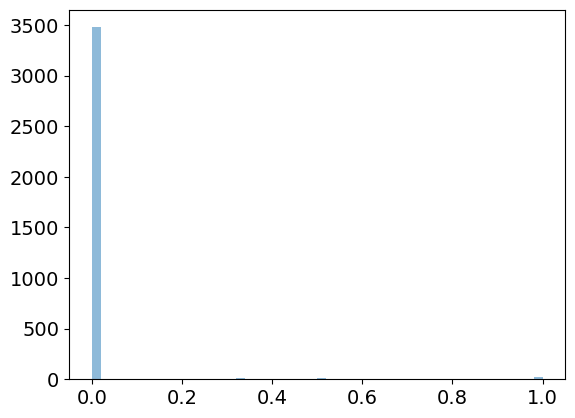

In [21]:
#plt.hist(battle_data_df.news_proportion_left_leaning_a, bins=50, alpha=0.5)
#plt.hist(battle_data_df.news_proportion_right_leaning_a, bins=50, alpha=0.5)
plt.hist(battle_data_df.news_proportion_unknown_leaning_a, bins=50, alpha=0.5)

In [25]:
(battle_data_df.news_proportion_left_leaning_b + battle_data_df.news_proportion_right_leaning_b + battle_data_df.news_proportion_unknown_leaning_b).value_counts()

1.000000    2345
0.000000     936
0.500000     155
0.333333      34
0.250000      17
0.666667      13
0.750000       8
0.666667       4
1.000000       4
0.142857       3
0.100000       3
0.285714       2
0.600000       2
0.125000       2
0.166667       2
0.400000       1
0.800000       1
0.222222       1
0.111111       1
0.400000       1
0.263158       1
0.833333       1
0.136364       1
0.933333       1
0.444444       1
0.200000       1
0.181818       1
0.800000       1
Name: count, dtype: int64

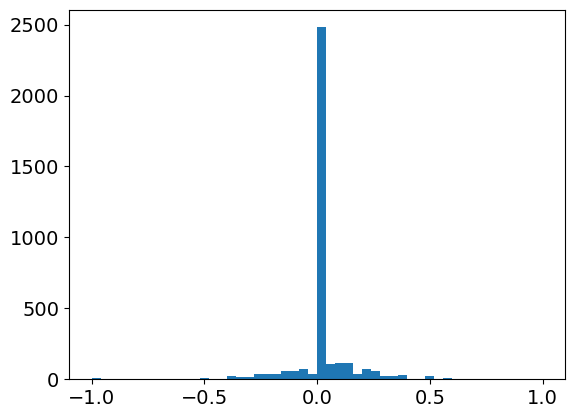

In [179]:
feature_to_check = "proportion_low_quality_diff"
plt.hist((battle_data_df['winner'] == 'model_a').astype(int) * battle_data_df[feature_to_check], bins=50);

SignificanceResult(statistic=np.float64(0.11926193540601329), pvalue=np.float64(1.0655273566962123e-12))

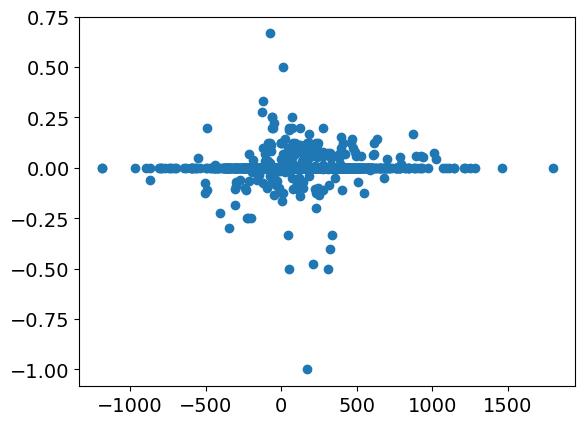

In [202]:
a = (battle_data_df['winner'] == 'model_a').astype(int) * battle_data_df['response_word_count_diff']
b = (battle_data_df['winner'] == 'model_a').astype(int) * battle_data_df['proportion_community_blog_diff']
plt.scatter(a, b)
spearmanr(a, b)

SignificanceResult(statistic=np.float64(0.4577845777490863), pvalue=np.float64(4.331035297853298e-183))

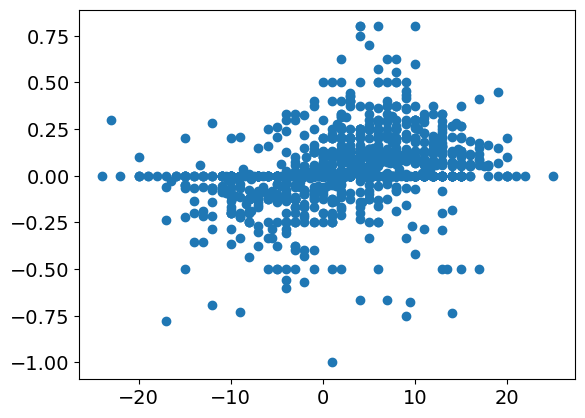

In [205]:
a = (battle_data_df['winner'] == 'model_a').astype(int) * battle_data_df['num_citations_diff']
b = (battle_data_df['winner'] == 'model_a').astype(int) * battle_data_df['proportion_social_media_diff']
plt.scatter(a, b)
spearmanr(a, b)

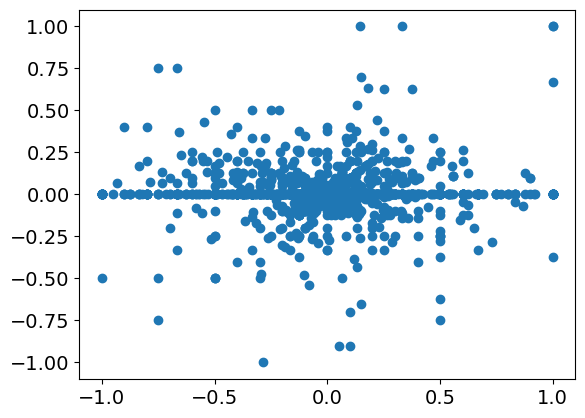

In [187]:
plt.scatter(
    (battle_data_df['winner'] == 'model_a').astype(int) * battle_data_df['proportion_news_diff'],
    (battle_data_df['winner'] == 'model_a').astype(int) * battle_data_df['proportion_right_leaning_diff']
)

In [140]:
battle_data_df.query("winder == 'model_a'")

,thread_id,model_a,model_b,winner,num_responses_a,num_responses_b,primary_intent,secondary_intent,total_turns,response_length_a,...,proportion_wiki_diff,proportion_gov_edu_diff,proportion_tech_diff,proportion_search_engine_diff,proportion_community_blog_diff,proportion_other_diff,model_a_family,model_b_family,family_matchup,cross_family_battle
0,thread_00000001,gpt-4o-mini-search-preview,sonar-pro,model_a,1,1,Explanation,Unassigned,1,1644.0,...,-0.083333,-0.416667,0.0,0.0,0.0,0.000000,openai,perplexity,openai_vs_perplexity,True
1,thread_00000002,sonar-reasoning,sonar-pro,model_b,1,1,Info Synthesis,Factual Lookup,1,5606.0,...,0.100000,0.100000,0.0,0.0,0.0,0.000000,perplexity,perplexity,perplexity_vs_perplexity,False
2,thread_00000005,gpt-4o-mini-search-preview,sonar,model_b,1,1,Factual Lookup,Unassigned,1,3259.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,openai,perplexity,openai_vs_perplexity,True
3,thread_00000007,gpt-4o-search-preview,sonar-pro,model_b,1,1,Factual Lookup,Unassigned,1,1834.0,...,0.000000,-0.166667,0.0,0.0,0.0,0.000000,openai,perplexity,openai_vs_perplexity,True
4,thread_00000008,sonar,sonar-reasoning,model_b,1,1,Factual Lookup,Unassigned,1,2614.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,perplexity,perplexity,perplexity_vs_perplexity,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3538,thread_00024046,gemini-2.5-flash-preview-04-17-grounding,sonar-pro-high,model_b,1,1,Info Synthesis,Analysis,1,8190.0,...,0.000000,0.033333,0.0,0.0,0.0,-0.100000,other,perplexity,other_vs_perplexity,True
3539,thread_00024047,sonar-reasoning-pro-high,sonar-reasoning-pro-high,model_a,1,1,Info Synthesis,Analysis,1,6655.0,...,0.000000,-0.100000,0.0,0.0,0.0,0.100000,perplexity,perplexity,perplexity_vs_perplexity,False
3540,thread_00024050,gpt-4o-search-preview,sonar-pro-high,model_b,1,1,Info Synthesis,Analysis,1,1984.0,...,1.000000,-0.300000,0.0,0.0,0.0,0.000000,openai,perplexity,openai_vs_perplexity,True
3541,thread_00024054,sonar-reasoning-pro-high,gpt-4o-search-preview,model_a,1,1,Info Synthesis,Unassigned,1,6322.0,...,-0.500000,0.000000,0.0,0.0,0.1,0.100000,perplexity,openai,perplexity_vs_openai,True


# Check output

In [133]:
coeffs = pd.read_csv("../data/intermediate/preference_analysis/preference_coefficients.csv")

In [128]:
ratings_df = coeffs.query("analysis_type == 'bradley_terry_rating'").copy()

In [129]:
ratings_df['scaled_rating'] = ratings_df.coefficient * 400 + 1000

In [131]:
ratings_df.sort_values(by='scaled_rating')

,analysis_type,feature,coefficient,ci_lower,ci_upper,significant,n_battles,scaled_rating
4,bradley_terry_rating,gpt-4o-mini-search-preview,-0.862542,NaN,NaN,NaN,3543,654.983079
6,bradley_terry_rating,gpt-4o-search-preview-high,-0.570545,NaN,NaN,NaN,3543,771.781952
3,bradley_terry_rating,gemini-2.5-pro-exp-03-25-wo-search,-0.566661,NaN,NaN,NaN,3543,773.335528
7,bradley_terry_rating,gpt-4o-search-preview-high-loc,-0.557412,NaN,NaN,NaN,3543,777.035325
0,bradley_terry_rating,gemini-2.0-flash-grounding,-0.294735,NaN,NaN,NaN,3543,882.105831
1,bradley_terry_rating,gemini-2.5-flash-preview-04-17-grounding,0.137316,NaN,NaN,NaN,3543,1054.926327
8,bradley_terry_rating,sonar,0.218676,NaN,NaN,NaN,3543,1087.470481
9,bradley_terry_rating,sonar-pro,0.264079,NaN,NaN,NaN,3543,1105.631773
11,bradley_terry_rating,sonar-reasoning,0.411977,NaN,NaN,NaN,3543,1164.790727
10,bradley_terry_rating,sonar-pro-high,0.428927,NaN,NaN,NaN,3543,1171.570939


In [134]:
coeffs

,analysis_type,feature,coefficient,ci_lower,ci_upper,significant,n_battles
0,bradley_terry_rating,gemini-2.0-flash-grounding,-0.294735,NaN,NaN,NaN,3543
1,bradley_terry_rating,gemini-2.5-flash-preview-04-17-grounding,0.137316,NaN,NaN,NaN,3543
2,bradley_terry_rating,gemini-2.5-pro-exp-03-25-grounding,0.707183,NaN,NaN,NaN,3543
3,bradley_terry_rating,gemini-2.5-pro-exp-03-25-wo-search,-0.566661,NaN,NaN,NaN,3543
4,bradley_terry_rating,gpt-4o-mini-search-preview,-0.862542,NaN,NaN,NaN,3543
5,bradley_terry_rating,gpt-4o-search-preview,1000.000000,NaN,NaN,NaN,3543
6,bradley_terry_rating,gpt-4o-search-preview-high,-0.570545,NaN,NaN,NaN,3543
7,bradley_terry_rating,gpt-4o-search-preview-high-loc,-0.557412,NaN,NaN,NaN,3543
8,bradley_terry_rating,sonar,0.218676,NaN,NaN,NaN,3543
9,bradley_terry_rating,sonar-pro,0.264079,NaN,NaN,NaN,3543


In [56]:
citations_enriched_df = pd.read_parquet("../data/intermediate/cleaned_arena_data/citations_enriched.parquet")

In [58]:
citations_enriched_df.political_leaning.value_counts()

political_leaning
unknown_leaning    171202
center_leaning     144968
left_leaning        48573
right_leaning        1344
Name: count, dtype: int64

In [59]:
pd.read_parquet("../data/intermediate/preference_analysis/news_competitions_citations.parquet")

,citation_id,response_id,citation_number,url,domain_full,domain,url_valid,citation_order,political_leaning_score,political_leaning,domain_quality_score,domain_quality,domain_classification
0,cite_00000063,resp_00000010,1,https://www.zmescience.com/science/geology/wor...,zmescience.com,zmescience.com,True,0,-0.344507,left_leaning,0.891073,high_quality,news
1,cite_00000064,resp_00000010,2,https://www.livescience.com/rarest-mineral-on-...,livescience.com,livescience.com,True,1,-0.231039,center_leaning,0.475796,low_quality,news
2,cite_00000065,resp_00000010,3,https://www.huffingtonpost.es/economia/oro-des...,huffingtonpost.es,huffingtonpost.es,True,2,-0.529342,left_leaning,NaN,unknown_quality,unclassified
3,cite_00000066,resp_00000010,4,https://www.ft.com/content/f3ee7cad-4280-4285-...,ft.com,ft.com,True,3,-0.308862,center_leaning,0.930139,high_quality,news
4,cite_00000067,resp_00000011,1,https://www.geologyin.com/2023/01/the-rarest-m...,geologyin.com,geologyin.com,True,0,-0.230978,center_leaning,0.279870,low_quality,news
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25508,cite_00365800,resp_00065714,10,https://www.upmarket.co/blog/the-best-ai-chatb...,upmarket.co,upmarket.co,True,9,NaN,unknown_leaning,NaN,unknown_quality,unclassified
25509,cite_00365801,resp_00065715,1,https://www.reuters.com/technology/openai-laun...,reuters.com,reuters.com,True,0,-0.224065,center_leaning,1.000000,high_quality,news
25510,cite_00365802,resp_00065715,2,https://en.wikipedia.org/wiki/DeepSeek_(chatbot),en.wikipedia.org,wikipedia.org,True,1,-0.246107,center_leaning,0.834071,high_quality,wiki
25511,cite_00365803,resp_00065715,3,https://en.wikipedia.org/wiki/Google_DeepMind,en.wikipedia.org,wikipedia.org,True,2,-0.246107,center_leaning,0.834071,high_quality,wiki


In [53]:
news_competitions_df = pd.read_parquet("../data/intermediate/preference_analysis/news_competitions.parquet")

In [54]:
len(news_competitions_df)

1534

In [50]:
len(news_competitions_df)

1534

In [60]:
domain_enriched_df = pd.read_parquet("../data/intermediate/cleaned_arena_data/domains_enriched.parquet")

In [87]:
domain_enriched_df.query('domain_classification == "news"').head(50)

,domain,citation_count,political_leaning_score,political_leaning,domain_quality_score,domain_quality,domain_classification
6,reuters.com,2051,-0.224065,center_leaning,1.000000,high_quality,news
11,apnews.com,1225,-0.209580,center_leaning,0.998049,high_quality,news
24,bbc.com,698,-0.263935,center_leaning,0.881686,high_quality,news
26,yahoo.com,618,-0.072625,center_leaning,0.692128,high_quality,news
29,axios.com,565,-0.289398,center_leaning,0.897142,high_quality,news
30,ft.com,550,-0.308862,center_leaning,0.930139,high_quality,news
35,indiatimes.com,481,-0.202084,center_leaning,0.388110,low_quality,news
39,163.com,468,-0.301472,center_leaning,NaN,unknown_quality,news
40,sohu.com,467,-0.212038,center_leaning,0.415152,low_quality,news
45,forbes.com,446,-0.125564,center_leaning,0.829500,high_quality,news


In [65]:
domain_enriched_df.query("domain_quality == 'low_quality'").head(20)

,domain,citation_count,political_leaning_score,political_leaning,domain_quality_score,domain_quality,domain_classification
0,youtube.com,19749,-0.022156,center_leaning,0.375093,low_quality,social_media
35,indiatimes.com,481,-0.202084,center_leaning,0.388110,low_quality,news
40,sohu.com,467,-0.212038,center_leaning,0.415152,low_quality,news
262,ria.ru,99,-0.364747,left_leaning,0.342842,low_quality,news
293,chosun.com,91,-0.445703,left_leaning,0.494617,low_quality,news
345,livescience.com,79,-0.231039,center_leaning,0.475796,low_quality,news
347,xinhuanet.com,79,-0.200595,center_leaning,0.307587,low_quality,news
682,gotquestions.org,45,0.385590,right_leaning,0.167814,low_quality,news
713,chinadaily.com.cn,44,-0.201815,center_leaning,0.371587,low_quality,news
973,rt.com,33,-0.087826,center_leaning,0.293277,low_quality,news


In [66]:
response_metrics = pd.read_parquet("../data/intermediate/preference_analysis/news_competitions_response_signals.parquet")

In [82]:
is_close_array = np.isclose(response_metrics[[
    'proportion_center_leaning',
    'proportion_left_leaning',
    'proportion_right_leaning',
    'proportion_unknown_leaning'
]].sum(axis=1), response_metrics['proportion_news'])

In [85]:
is_close_array = np.isclose(response_metrics[[
    'proportion_low_quality',
    'proportion_high_quality',
    'proportion_unknown_quality'
]].sum(axis=1), response_metrics['proportion_news'])

In [86]:
pd.Series(is_close_array).value_counts()

True    21004
Name: count, dtype: int64

In [75]:
temp_df.value_counts()

True     20843
False      161
Name: count, dtype: int64

In [76]:
temp_df[~temp_df]

118      False
151      False
158      False
457      False
537      False
         ...  
20814    False
20849    False
20910    False
20916    False
20938    False
Length: 161, dtype: bool

In [71]:
response_metrics['proportion_news']

0        0.000000
1        0.166667
2        0.000000
3        0.100000
4        0.000000
           ...   
20999    0.000000
21000    0.000000
21001    0.000000
21002    0.000000
21003    0.000000
Name: proportion_news, Length: 21004, dtype: float64

In [78]:
response_metrics.loc[118]

response_id                                                            resp_00000208
question_id                                                               q_00000104
thread_id                                                            thread_00000092
turn_number                                                                       10
model_name_llm                                                 gpt-4o-search-preview
model_name_raw                                                 gpt-4o-search-preview
model_side                                                                         a
response_text                      I understand your frustration with the limitat...
response_role                                                              assistant
citation_format                                                             original
llm_temperature                                                                  NaN
llm_top_p                                                        